In [1]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestRegressor , VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae 
from xgboost import XGBRegressor
import xgboost as xgb

In [2]:
df = pd.read_csv("/Users/Tata/Downloads/house-prices-advanced-regression-techniques/temp_train.csv")
X = df.drop(columns='SalePrice')  # Features (all columns except 'price')
y = df['SalePrice'] 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_val, y_val], axis=1)
test_data_no_price = test_data.drop(columns=['SalePrice'])
actual = test_data['SalePrice']

In [29]:
#Linear Regression
reg = linear_model.LinearRegression()
X = train_data.drop(columns=['SalePrice'])
y = train_data['SalePrice']
reg.fit(X,y)
pred = reg.predict(test_data_no_price)

In [45]:
def get_residuals(pred):
    return np.abs(actual - pred)

In [52]:

error = mae(actual, pred)  
print("Mean absolute error : " + str(error))

Mean absolute error : 21092.33638519298


In [53]:
line_model = LinearRegression()
line_model.fit(actual.values.reshape(-1, 1), pred)
slope = line_model.coef_[0]
intercept = line_model.intercept_

In [64]:
def with_out(pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, pred, alpha=0.5, label='Predicted vs Actual')

    plt.xlabel('Actual SalePrice')
    plt.ylabel('Predicted SalePrice')
    plt.title('Actual vs Predicted SalePrice with Outliers')
    plt.legend()
    plt.show()

    # Print the regression line equation
    print(f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")
    r2 = r2_score(y_val, pred)
    print(r2)

In [57]:
def filter_data(pred,residuals=get_residuals(pred)):
    Q1 = np.percentile(residuals, 25)
    Q3 = np.percentile(residuals, 75)
    IQR = Q3 - Q1

    # Determine the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)
    filtered_actual = actual[mask]
    filtered_pred = pred[mask]

    plt.figure(figsize=(10, 6))

    # Plot the actual and predicted values without outliers
    plt.scatter(filtered_actual, filtered_pred, alpha=0.6, label='Predicted vs Actual')
    plt.plot([filtered_actual.min(), filtered_actual.max()], [filtered_actual.min(), filtered_actual.max()], color='red', linestyle='--', label='Perfect Prediction Line')

    # Add labels and title
    plt.xlabel('Actual SalePrice')
    plt.ylabel('Predicted SalePrice')
    plt.title('Actual vs Predicted SalePrice without Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()
    return filtered_actual,filtered_pred











In [60]:
def plot_act_vs_pred(filtered_actual,filtered_pred):
    error = mae(filtered_actual, filtered_pred)  
    print("Mean absolute error : " + str(error))
    r2_filtered = r2_score(filtered_actual, filtered_pred)
    print(f'R² value for the filtered data: {r2_filtered}')
    textstr = f'R²: {r2_filtered:.2f}\nMAE: {error:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.figure(figsize=(10, 6))

    # Plot the actual and predicted lines without outliers
    plt.plot(range(len(filtered_actual)), filtered_actual, color='blue', linestyle='-', linewidth=2, label='Actual Line')
    plt.plot(range(len(filtered_pred)), filtered_pred, color='green', linestyle='-', linewidth=2, label='Prediction Line')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('SalePrice')
    plt.title('Actual vs Predicted SalePrice without Outliers')
    plt.legend()
    plt.grid(True)
    plt.text(0.82, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
    plt.show()

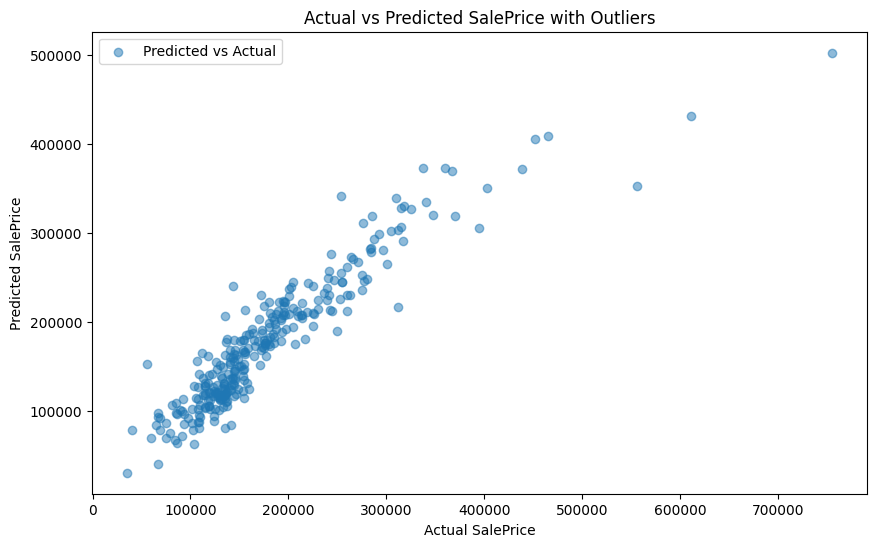

Regression Line: y = 0.80x + 33806.92
0.8543207891669916


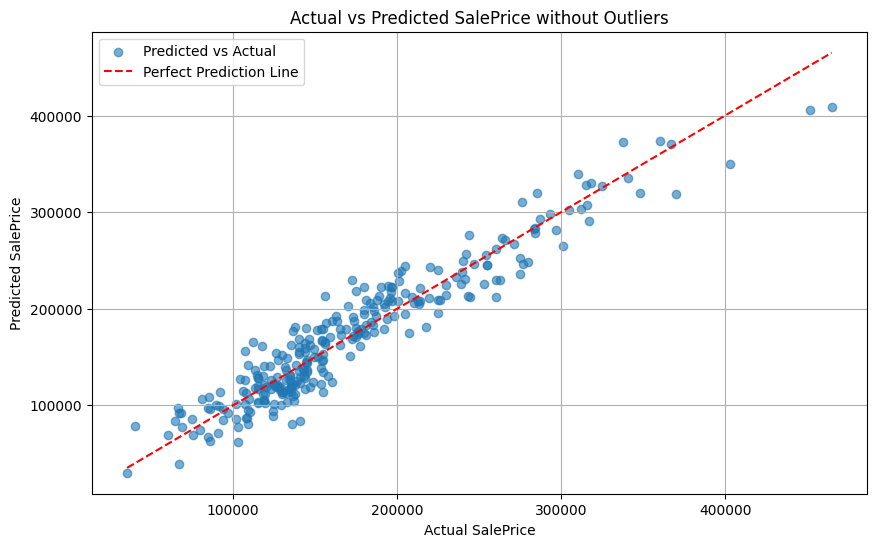

Mean absolute error : 17285.334387132167
R² value for the filtered data: 0.9061215991775062


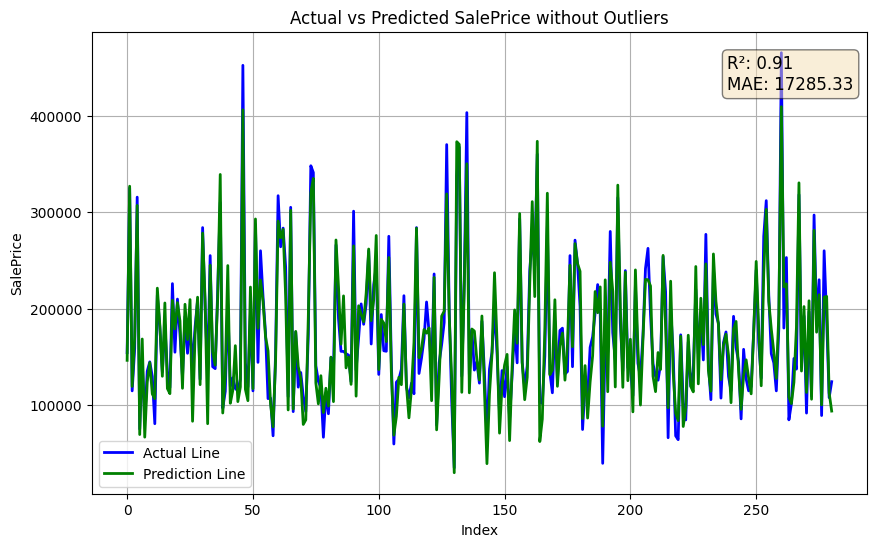

In [65]:
with_out(pred)
filtered_actual, filtered_pred = filter_data(pred)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 8, 10],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],  # Number of features to consider at each split
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1],  # Complexity parameter used for Minimal Cost-Complexity Pruning
    'max_leaf_nodes': [None, 10, 20, 30, 50],  # Grow trees with max_leaf_nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]  # Minimum impurity decrease required to split a node
}

# Regression Tree
DtReg = DecisionTreeRegressor(random_state=42)

# Use RandomizedSearchCV to sample from the parameter grid
random_search = RandomizedSearchCV(
    estimator=DtReg, 
    param_distributions=param_grid, 
    n_iter=500,  # Number of parameter settings that are sampled
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='r2',
    random_state=42  # Ensures reproducibility of results
)

# Fit the RandomizedSearchCV object
random_search.fit(X, y)

# Retrieve the best parameters and score after fitting
best_params = random_search.best_params_
print("Best Parameters:", best_params)
#Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 40, 'max_features': 'sqrt', 'max_depth': 30, 'ccp_alpha': 0.1}



Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[CV] END ccp_alpha=0.0, max_depth=40, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, max_depth=40, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, max_depth=40, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, max_depth=40, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, max_depth=40, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, max_depth=None, max_features=auto, max_leaf_nodes=30, min_impurity_decrease=0.05, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END ccp_a

In [17]:
#Regression Tree
DtReg = DecisionTreeRegressor(random_state=42,min_samples_split = 2, min_samples_leaf = 10, min_impurity_decrease = 0.0, max_leaf_nodes = 50, max_features =0.8, max_depth= None, ccp_alpha = 0.0)
DtReg_norm = DecisionTreeRegressor(random_state=42)
# {'min_samples_split': 2, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 50, 'max_features': 0.8, 'max_depth': None, 'ccp_alpha': 0.0}DtReg.fit(X,y)
DtReg_norm.fit(X,y)
DtReg.fit(X,y)


DecisionTreeRegressor(max_features=0.8, max_leaf_nodes=50, min_samples_leaf=10,
                      random_state=42)

In [18]:
y_predict_dtr = DtReg.predict((test_data_no_price))
y_predict_dtr_norm = DtReg_norm.predict((test_data_no_price))
r2_dtr = r2_score(y_val, y_predict_dtr)
r2_dtr_norm = r2_score(y_val, y_predict_dtr_norm)
print(r2_dtr,r2_dtr_norm)   

0.7260049305847349 0.7628296420930123


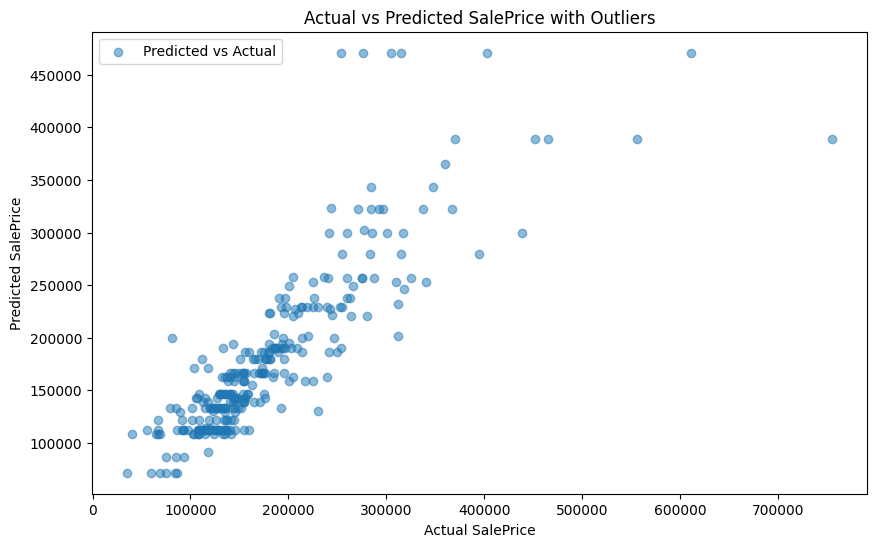

Regression Line: y = 0.80x + 33806.92
0.7260049305847349


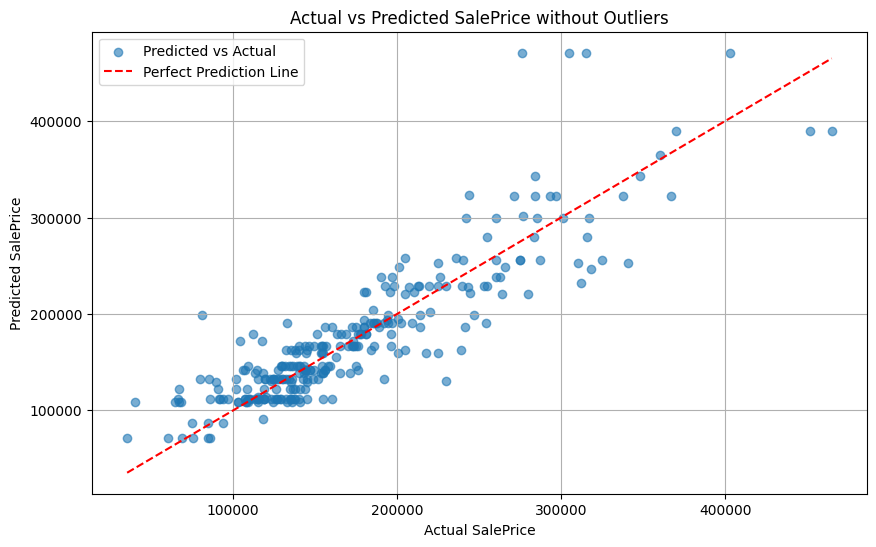

Mean absolute error : 23111.300703142428
R² value for the filtered data: 0.7647825815252974


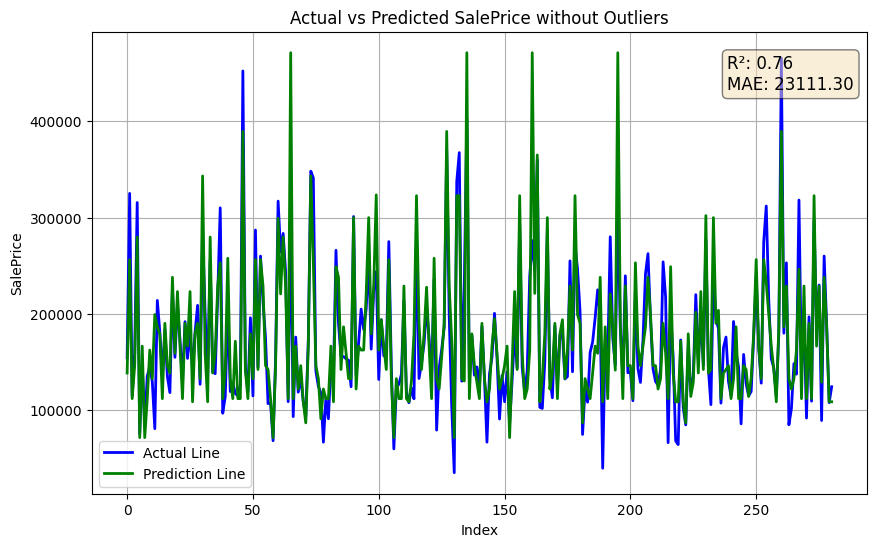

In [66]:
with_out(y_predict_dtr)
filtered_actual, filtered_pred = filter_data(y_predict_dtr)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 8, 10],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1],  # Complexity parameter used for Minimal Cost-Complexity Pruning
    'max_leaf_nodes': [None, 10, 20, 30, 50]  # Grow trees with max_leaf_nodes in best-first fashion
}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=50, 
                                   cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X, y)

print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)


Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 0.2, 'max_depth': 10, 'ccp_alpha': 0.1, 'bootstrap': False}
Best R^2 Score: 0.8490065152552845


In [37]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=500, 
                           max_depth=10, min_samples_split=2, 
                           min_samples_leaf=2, max_leaf_nodes= None ,max_features=0.2, bootstrap= False,
                           ccp_alpha=0.1)
rf.fit(X, y)
y_predict_rf = rf.predict(test_data_no_price)


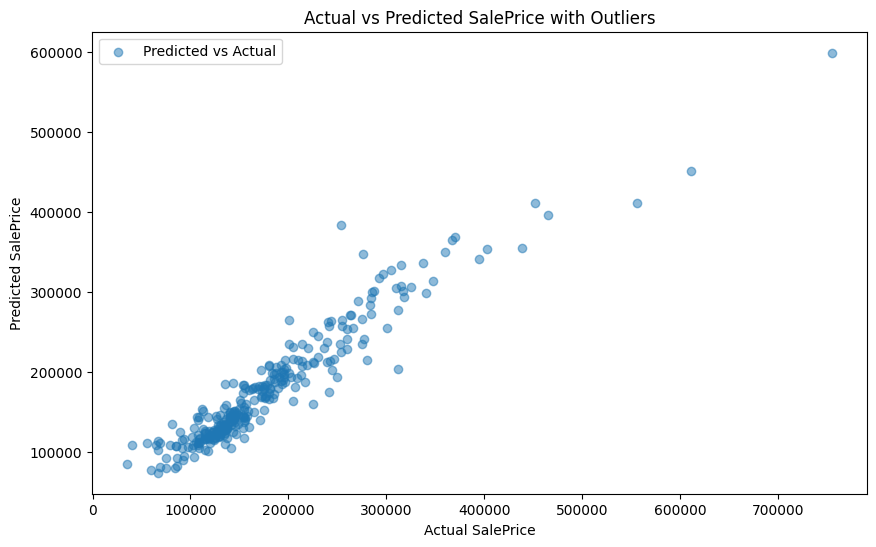

Regression Line: y = 0.80x + 33806.92
0.8938679096179513


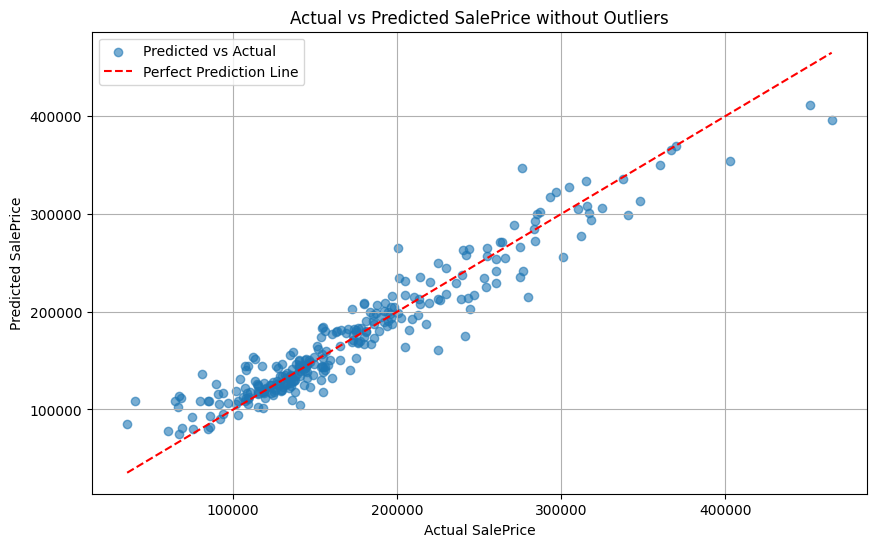

Mean absolute error : 14509.471945042209
R² value for the filtered data: 0.9166616035240557


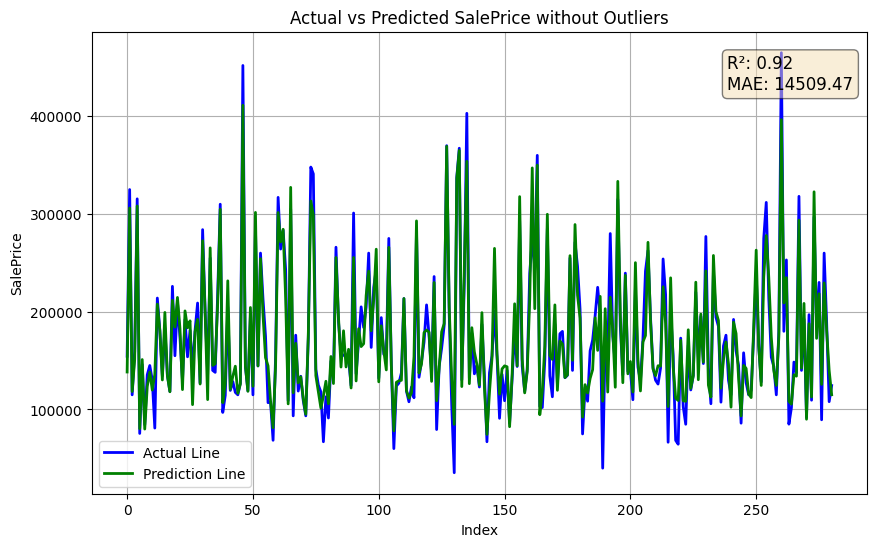

In [68]:
with_out(y_predict_rf)
filtered_actual, filtered_pred = filter_data(y_predict_rf)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [71]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500, 700],  # Number of boosting rounds
    'max_depth': [None, 3, 6, 10, 15],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'min_child_weight': [1, 2, 5, 10],  # Minimum sum of instance weight (hessian) in a child
    'gamma': [0, 0.1, 0.2, 0.5],  # Minimum loss reduction to make a further partition
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting individual trees
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Fraction of features to be used by the model
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term
    'reg_lambda': [1, 0.5, 0.1],  # L2 regularization term
    'scale_pos_weight': [1, 0.8, 0.5],  # Balancing of positive and negative weights
}

# Initialize XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb, 
                                       param_distributions=param_grid_xgb, 
                                       n_iter=100,  # Number of different combinations to try
                                       scoring='neg_mean_squared_error', 
                                       cv=5,  # 5-fold cross-validation
                                       verbose=2, 
                                       n_jobs=-1, 
                                       random_state=42)

# Fit RandomizedSearchCV
random_search_xgb.fit(X, y)

# Get the best parameters and score
best_params = random_search_xgb.best_params_


print(f"Best Parameters: {best_params}")



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=None, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300, reg_alpha=0.1, reg_lambda

In [74]:

# Initialize XGBoost Regressor with parameters similar to your RandomForestRegressor setup
xgb = XGBRegressor(
    subsample=0.6,            # Fraction of samples used for fitting individual trees
    scale_pos_weight=1,       # Balance of positive and negative weights
    reg_lambda=0.5,           # L2 regularization term on weights
    reg_alpha=1,              # L1 regularization term on weights
    n_estimators=700,         # Number of boosting rounds
    min_child_weight=10,      # Minimum sum of instance weight (hessian) in a child
    max_depth=10,              # Maximum depth of a tree
    learning_rate=0.05,       # Step size shrinkage used in update to prevent overfitting
    gamma=0.2,                # Minimum loss reduction required to make a further partition
    colsample_bytree=0.3,     # Fraction of features to be used for each tree
    objective='reg:squarederror',  # Objective function for regression
    random_state=42           # Ensure reproducibility
)
# Fit the model
xgb.fit(X, y)

y_predict_xgb = xgb.predict(test_data_no_price)


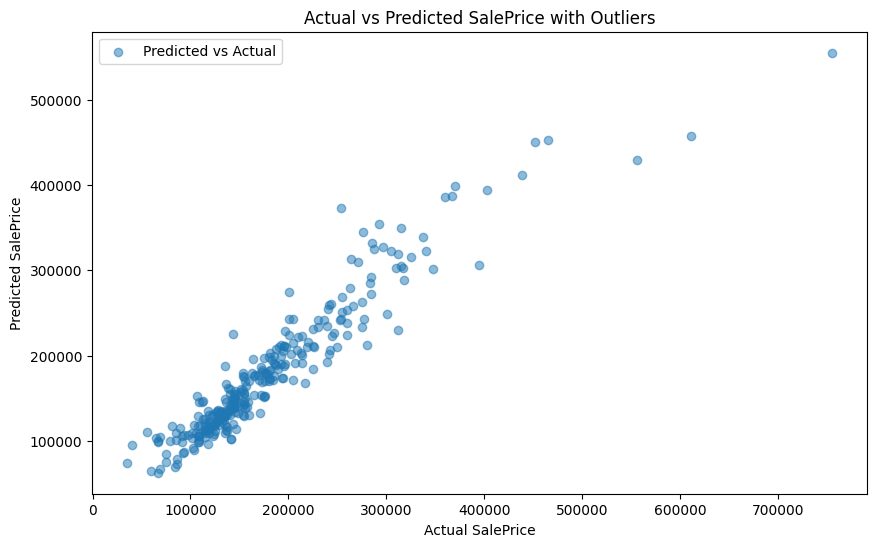

Regression Line: y = 0.80x + 33806.92
0.8938702385654369


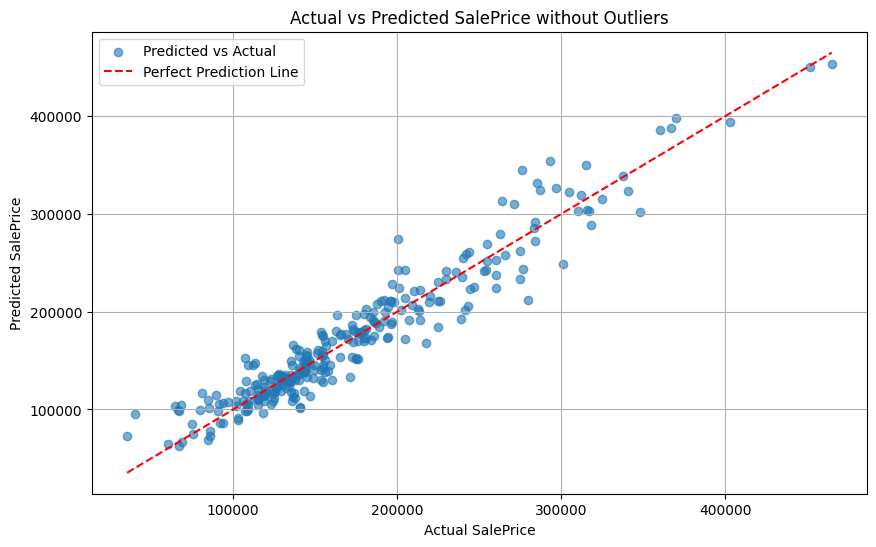

Mean absolute error : 14871.259105315836
R² value for the filtered data: 0.9189542505735994


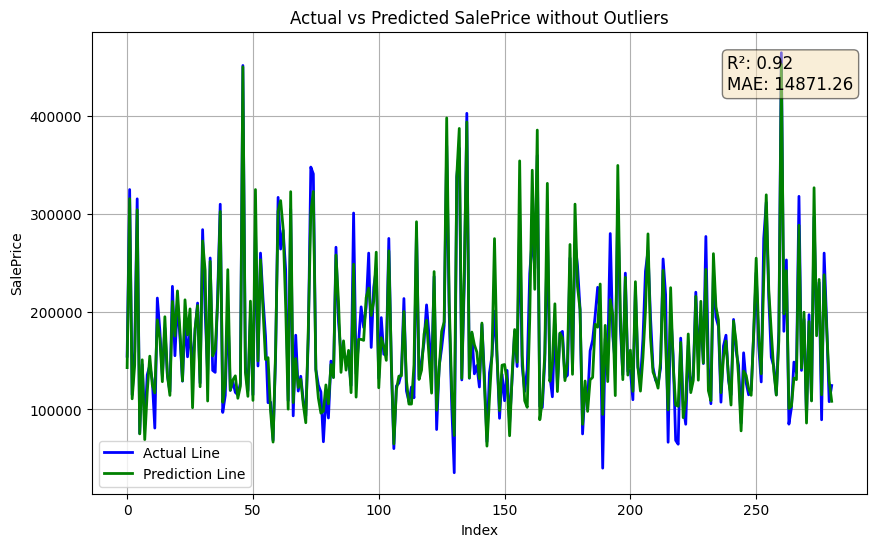

In [75]:
with_out(y_predict_xgb)
filtered_actual, filtered_pred = filter_data(y_predict_xgb)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [79]:
from sklearn.model_selection import cross_val_score
# Define the model combinations and weights to try
weights_list = [
    [1, 1, 1, 1],   # Equal weights
    [0,0,1,1]   # More weight on LR and Tree
    # Add more combinations as needed
]

best_score = float('-inf')
best_weights = None

# Iterate over different weight combinations
for weights in weights_list:
    voting_regressor = VotingRegressor([
        ('lr', reg),
        ('tree', DtReg),
        ('rf', rf),
        ('xgb', xgb)
    ], weights=weights)
    
    # Perform cross-validation
    cv_scores = cross_val_score(voting_regressor, X, y, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)
    
    print(f"Weights: {weights}, Mean R²: {mean_cv_score}")
    
    # Update best weights if this combination is better
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_weights = weights

print(f"Best Weights: {best_weights}, Best R²: {best_score}")

Weights: [1, 1, 1, 1], Mean R²: 0.854505035685596
Weights: [0, 0, 1, 1], Mean R²: 0.8632870768185164
Best Weights: [0, 0, 1, 1], Best R²: 0.8632870768185164


In [77]:
voting_regressor = VotingRegressor([
    ('lr', reg),
    ('tree', DtReg),
    ('rf', rf),
    ('xgb', xgb)
], weights=[0, 0, 1, 1])
voting_regressor.fit(X, y)
v_pred = voting_regressor.predict(test_data_no_price)


In [110]:
df = pd.read_csv("/Users/Tata/Downloads/HousePricing/train_data.csv")
test = pd.read_csv("/Users/Tata/Downloads/house-prices-advanced-regression-techniques/testy.csv")
X = df.drop(columns='SalePrice')  # Features (all columns except 'price')
y = df['SalePrice'] 

In [114]:

X = X.sample(len(X) - 1, random_state=42)
y = y.sample(len(y) - 1, random_state=42)  # Drop one random row, keep the rest
test = test.sample(len(test) - 1, random_state=42)
#Linear Regression
reg = linear_model.LinearRegression()
reg.fit(X,y)
pred = reg.predict(test)

In [ ]:

def get_residuals_org(pred):
    return np.abs(y - pred)

def filter_data_org(pred,residuals=get_residuals_org(pred)):
    Q1 = np.percentile(residuals, 25)
    Q3 = np.percentile(residuals, 75)
    IQR = Q3 - Q1

    # Determine the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)
    filtered_actual = y[mask]
    filtered_pred = pred[mask]

    plt.figure(figsize=(10, 6))

    # Plot the actual and predicted values without outliers
    plt.scatter(filtered_actual, filtered_pred, alpha=0.6, label='Predicted vs Actual')
    plt.plot([filtered_actual.min(), filtered_actual.max()], [filtered_actual.min(), filtered_actual.max()], color='red', linestyle='--', label='Perfect Prediction Line')

    # Add labels and title
    plt.xlabel('Actual SalePrice')
    plt.ylabel('Predicted SalePrice')
    plt.title('Actual vs Predicted SalePrice without Outliers')
    plt.legend()
    plt.grid(True)
    plt.show()
    return filtered_actual,filtered_pred











In [ ]:
with_out(pred)
filtered_actual, filtered_pred = filter_data_org(pred)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [ ]:
with_out(y_predict_xgb)
filtered_actual, filtered_pred = filter_data_org(y_predict_xgb)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [ ]:
with_out(y_predict_rf)
filtered_actual, filtered_pred = filter_data_org(y_predict_rf)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [ ]:
with_out(y_predict_dtr)
filtered_actual, filtered_pred = filter_data_org(y_predict_dtr)
plot_act_vs_pred(filtered_actual,filtered_pred)

In [ ]:
ids = list(range(1461, 2920))
submission = pd.DataFrame({
    'Id': ids,  # Use the generated IDs
    'SalePrice': v_pred  # Predictions from your model
})
submission = submission[['Id', 'SalePrice']]

# Save the submission file with the specified column order
submission.to_csv('submissionvotingwithweight2.csv', index=False)